# Spectral Line Data Cubes in Astronomy - Part 2 (unfinished)

We are doing a complete re-analysis of the same NGC 6503 case, but now with more tools that the community has developed. For this you will need to modify your python environment.

See also http://adsabs.harvard.edu/abs/2015ASPC..499..363G for the paper describing this project.


In [1]:
%matplotlib inline

In [2]:
# python 2-3 compatibility
from __future__ import print_function

## Reading the data

Two new community modules are introduced here: *spectral_cube* and *radio_beam*, both from the https://github.com/radio-astro-tools project.

### Automated

We need to use **pip** to install these packages, since they are not part of anaconda.

    pip install spectral_cube
    pip install radio_beam
       

### Manual

    git clone https://github.com/radio-astro-tools/spectral_cube
    cd spectral_cube
    python setup.py install
    
    git clone https://github.com/radio-astro-tools/radio_beam
    cd radio_beam
    python setup.py install


In [3]:
import numpy as np
import astropy.units as u
from spectral_cube import SpectralCube
import radio_beam

In [4]:
cube = SpectralCube.read('../data/ngc6503.cube.fits')
print(cube)

SpectralCube with shape=(89, 251, 371) and unit=Jy:
 n_x:    371  type_x: RA---SIN  unit_x: deg    range:   266.676861 deg:  267.895600 deg
 n_y:    251  type_y: DEC--SIN  unit_y: deg    range:    70.007750 deg:   70.286667 deg
 n_s:     89  type_s: FREQ      unit_s: Hz     range: 1419177268.848 Hz:1421325706.348 Hz


/n/ursa/A288P/griffins/ASTR288P/software/miniconda3/lib/python3.6/site-packages/spectral_cube/spectral_cube.py:2031: UserWarning: Cube is a Stokes cube, returning spectral cube for I component
  warnings.warn("Cube is a Stokes cube, returning spectral cube for I component")


A FITS file consists of a series of Header-Data-Units (HDU). Usually there is only one, representing the image. But this file has two. For now, we're going to ignore the second, which is a special table and in this example happens to be empty anyways.  Each HDU has a header, and data.  The data in this case is a numpy array, and represents the image (cube):

In [5]:
h = cube.header
d = cube.unmasked_data[:,:,:]
print(d.shape, d.min(), d.max(), d.mean(), np.median(d), d.std())
print("Signal/Noise  (S/N):",d.max()/d.std())


(89, 251, 371) -0.003157205879688263 Jy 0.016983529552817345 Jy 4.734359390567988e-05 Jy 1.3375308299146127e-05 Jy 0.0007403538911603391 Jy
Signal/Noise  (S/N): 22.939745107842224


From the shape (89,251,371) we can see this image is already 3 dimensional, the dummy 4th dimension we saw in the previous example is not present here. There are 371 pixels along X, 251 along Y, and 89 slices or spectral channels. 

In case you were wondering about that missing 4th redundant axis. This is possibly a simplification of the data model left out of spectal_cube at the moment.

The material below this should be the same as the previous "case1" notebook (even though the data array is not exactly just a numpy array, but a Quantity!)

## Plotting some basics

In [6]:
import matplotlib.pyplot as plt

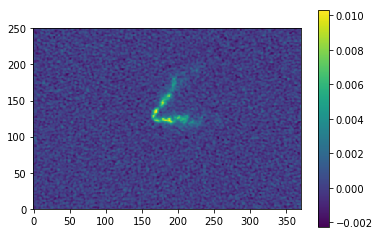

In [7]:
z = 35
im = d[z,:,:]                              #   im = d[z]     also works
plt.imshow(im,origin=['Lower'])
plt.colorbar()

There are 89 channels (slices) in this cube, numbered 0 through 88 in the usual python sense. Pick a few other slices by changing the value in 
**z=** and notice that the first few and last few appear to be just noise and that the V-shaped signal changes shape through the channels. Perhaps you should not be surprised that these are referred to as butterfly diagrams.

(8287769,)


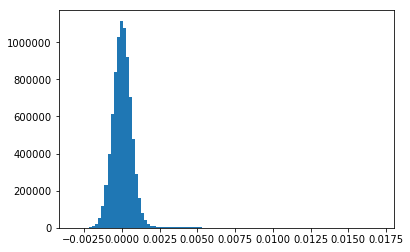

In [8]:
# look at a histogram of all the data (histogram needs a 1D array)
d1 = d.ravel()                 # ravel() doesn't make a new copy of the array, saving memory
print(d1.shape)
(n,b,p) = plt.hist(d1, bins=100)

Notice that the histogram is on the left in the plot, and we already saw the maximum data point is 0.0169835.

So let us plot the vertical axis logarithmically, so we can better see what is going on.

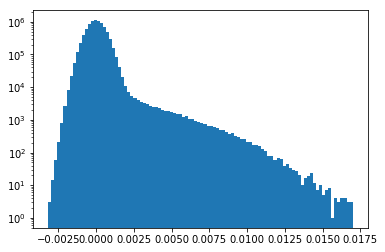

In [9]:
(n,b,p) = plt.hist(d1,bins=100,log=True)

-1.2134017879361636e-06 Jy 0.0005582924350164831 Jy


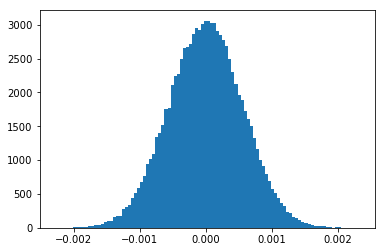

In [10]:
# pick a slice and make a histogram and print the mean and standard deviation of the signal in that slice
z=0
imz = d[z,:,:].flatten()
(n,b,p) = plt.hist(imz,bins=100)
print(imz.mean(), imz.std())


**Exercise** : observe by picking some values of **z** that the noise seems to vary a little bit from one end of the band to the other.  Store the noise in channel 0 and 88 in variables sigma0 and sigma88:


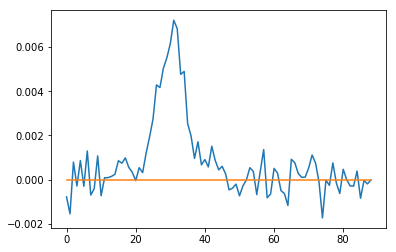

In [11]:
xpeak = 175
ypeak = 125
channel = np.arange(d.shape[0])
spectrum = d[:,ypeak,xpeak]
zero = spectrum * 0.0
plt.plot(channel,spectrum)
plt.plot(channel,zero)

In [12]:
sigma0 = 0.00056
sigma88 = 0.00059

In [13]:
import scipy.signal
import scipy.ndimage.filters as filters

## Smoothing a cube to enhance the signal to noise

(251, 371) -1.2134e-06 0.000186325


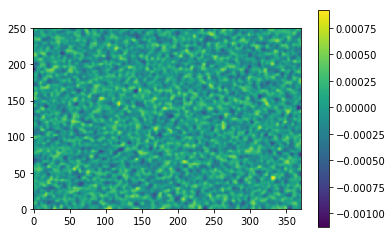

In [15]:
z = 0
sigma = 2.0
ds1 = filters.gaussian_filter(d[z],sigma)                    # ds1 is a single smoothed slice
print(ds1.shape, ds1.mean(), ds1.std())
plt.imshow(ds1,origin=['Lower'])
plt.colorbar()

Notice that the noise is indeed lower than your earlier value of sigma0.   We only smoothed one single slice, but we actually need to smooth the whole cube.  Each slice  with sigma, but we can optionally also smooth in the spectral dimension a little bit. 

0.010926 58.6394


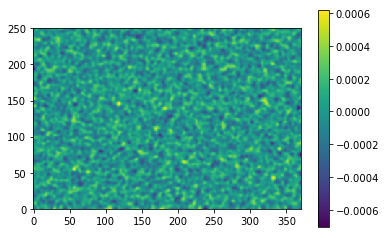

In [16]:
ds = filters.gaussian_filter(d,[1.0,sigma,sigma])              # ds is a smoothed cube
plt.imshow(ds[z],origin=['Lower'])
plt.colorbar()
print(ds.max(),ds.max()/ds1.std())

Notice that, although the peak value was lowered a bit due to the smoothing, the signal to noise has increased from the original cube. So, the signal should stand out a lot better.

**Exercise** : Observe a subtle difference in the last two plots. Can you see what happened here?

## Masking


In [17]:
import numpy.ma as ma

In [19]:
#  sigma0 is the noise in the original cube
nsigma = 0.0
dm = ma.masked_inside(d,-nsigma*sigma0,nsigma*sigma0)
print(dm.count())

8287769


PEAK at location: 149 113 42072


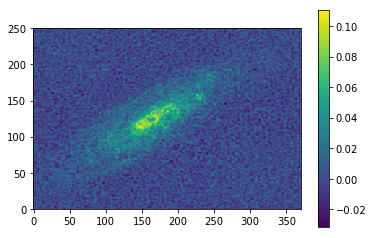

In [21]:
mom0 = dm.sum(axis=0)
plt.imshow(mom0,origin=['Lower'])
plt.colorbar()
#
(ypeak,xpeak) = np.unravel_index(mom0.argmax(),mom0.shape)
print("PEAK at location:",xpeak,ypeak,mom0.argmax())

In [ ]:
spectrum2 = ds[:,ypeak,xpeak]
plt.plot(channel,spectrum2)
plt.plot(channel,zero)

In [ ]:
mom0s = ds.sum(axis=0)
plt.imshow(mom0s,origin=['Lower'])
plt.colorbar()

## Velocity fields

The mean velocity is defined a the first moment

$$
<V> = {\Sigma{(v.I)} \over \Sigma{(I)} }
$$

MINMAX -925832.096554618 302361.32862007106


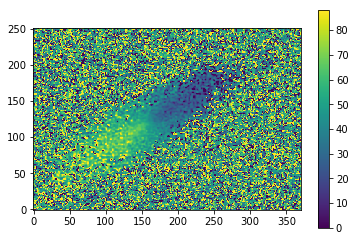

In [23]:
nz = d.shape[0]
vchan = np.arange(nz).reshape(nz,1,1)
vsum = vchan * d
vmean = vsum.sum(axis=0)/d.sum(axis=0)
print("MINMAX",vmean.min(),vmean.max())
plt.imshow(vmean,origin=['Lower'],vmin=0,vmax=88)
plt.colorbar()

Although we can recognize an area of coherent motions (the red and blue shifted sides of the galaxy), there is a lot of noise in this image. Looking at the math, we are dividing two numbers, both of which can be noise, so the outcome can be "anything".  If anything, it should be a value between 0 and 88, so we could mask for that and see how that looks.

Let us first try to see how the smoothed cube looked.

(251, 371) -379739.299007 1023678.63765


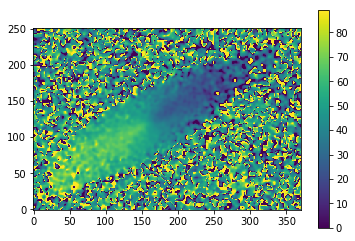

In [24]:
nz = ds.shape[0]
vchan = np.arange(nz).reshape(nz,1,1)
vsum = vchan * ds
vmean = vsum.sum(axis=0)/ds.sum(axis=0)
print(vmean.shape,vmean.min(),vmean.max())
plt.imshow(vmean,origin=['Lower'],vmin=0,vmax=89)
plt.colorbar()

Although more coherent, there are still bogus values outside the image of the galaxy. So we are looking for a hybrid of the two methods.  In the smooth cube we saw the signal to noise is a lot better defined, so we will define areas in the cube where the signal to noise is high enough and use those in the original high resolution cube.

2.96841e-07 0.000105553


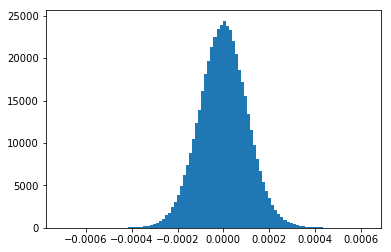

In [25]:
# this is all messy , we need a better solution, a hybrid of the two:
noise = ds[0:5].flatten()
(n,b,p) = plt.hist(noise,bins=100)
print(noise.mean(), noise.std())

In [26]:
sigma0 = noise.std()
nsigma = 5.0
cutoff = sigma0*nsigma
dm = ma.masked_inside(ds,-cutoff,cutoff)
print(cutoff,dm.count())

0.000527763331775 186888


In [27]:
dm2=ma.masked_where(ma.getmask(dm),d)

-9.472148232738704 Jy 91.77445089623832 Jy


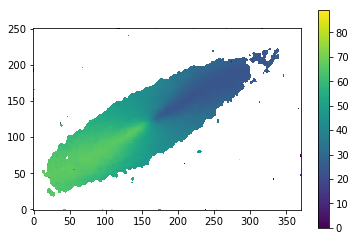

In [28]:
vsum = vchan * dm2
vmean = vsum.sum(axis=0)/dm2.sum(axis=0)
print(vmean.min(),vmean.max())
plt.imshow(vmean,origin=['Lower'],vmin=0,vmax=89)
plt.colorbar()

And voila, now this looks a lot better.